In [1]:
import pandas as pd
import numpy as np
import zstandard as zstd
import os
import random
import xlsxwriter

import networkx as nx
from networkx.algorithms import community, bipartite
import igraph as ig

import matplotlib.pyplot as plt
import seaborn
import scipy

## Load and prepare data

In [2]:
contracts = pd.read_csv('../data/raw/contracts.csv')
aggregated_country_year = pd.read_csv('../data/raw/aggregated_country_year.csv')

In [3]:
print(len(contracts))
print(len(aggregated_country_year))

4098711
234


In [4]:
contracts = contracts.drop(['Unnamed: 0'], axis=1)
contracts.head(3)

tender_id  year date_dispatched issuer_id_final   
0  2.150556e+09  2008      2008-12-11        248_LV_i  \
1  2.152665e+09  2012      2012-12-20        295_UK_i   
2  2.224763e+09  2008      2008-01-02       4555_PL_i   

                                         issuer_name   
0  Rēzeknes pilsētas Izglītības pārvalde, LV90000...  \
1  Chelsea & Westminster Hospital NHS Foundation ...   
2                    Zarząd Dróg i Zieleni w Gdańsku   

                               issuer_canonical_name issuer_country   
0  rezeknes pilsetas izglitibas parvalde lv900000...             LV  \
1  chelsea westminster hospital nhs foundation tr...             UK   
2                  zarzad drog i zieleni w gdansku_i             PL   

          issuer_address issuer_postcode issuer_town  ... contract_nuts   
0  Atbrīvošanas aleja 91            4600     Rēzekne  ...         LV005  \
1        369 Fulham Road        SW10 9NH      London  ...           NaN   
2     ul. Partyzantów 36          80-254      Gdańsk  ...           NaN   

  processed_nuts contract_cpv cpv2 contract_eu_funded contract_type   
0           LV00   74200000.0   74                0.0   1. Services  \
1             UK   33111800.0   33                0.0   2. Supplies   
2             PL   45233141.0   45                0.0      3. Works   

    procedure n_bids nocft  single_bidder  
0        open    4.0     0            0.0  
1  restricted    4.0     1            0.0  
2        open    1.0     0            1.0  

[3 rows x 31 columns]

In [5]:
aggregated_country_year = aggregated_country_year.drop(['Unnamed: 0'], axis=1)
aggregated_country_year.head(3)

country  year  ncontracts   sb_rate  nwinners  nissuers  nedges   
0      AT  2008        3192  0.094337      1815       456    2324  \
1      AT  2009        3148  0.100352      1906       429    2482   
2      AT  2010        3178  0.105601      1762       386    2339   

   non_core_sb_rate  core_ncontracts  core_sb_rate  ...  core_density   
0          0.121861              718      0.101374  ...      0.011840  \
1          0.074037              500      0.118953  ...      0.012833   
2          0.149497              647      0.091780  ...      0.011105   

   core_to_non_sb  core_contract_share  eqi_score  ti_cpi  wbgi_cce   
0        1.074591             0.224937        NaN    81.0  1.843035  \
1        1.185354             0.158831        NaN    79.0  1.703025   
2        0.869121             0.203587    1.06285    79.0  1.585462   

   vdem_corr  sb_rate_08_16  sb_clustering_vs_random  sb_core_vs_random  
0   0.139032       0.121968                 2.088365           0.902565  
1   0.139032       0.121968                 3.600993           0.945130  
2   0.139032       0.121968                 1.888154           0.796586  

[3 rows x 23 columns]

In [6]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4098711 entries, 0 to 4098710
Data columns (total 31 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tender_id              float64
 1   year                   int64  
 2   date_dispatched        object 
 3   issuer_id_final        object 
 4   issuer_name            object 
 5   issuer_canonical_name  object 
 6   issuer_country         object 
 7   issuer_address         object 
 8   issuer_postcode        object 
 9   issuer_town            object 
 10  issuer_type            object 
 11  issuer_sector          object 
 12  winner_id_final        object 
 13  winner_name            object 
 14  winner_canonical_name  object 
 15  winner_country         object 
 16  winner_address         object 
 17  winner_postcode        object 
 18  winner_town            object 
 19  est_value              float64
 20  contract_value         float64
 21  contract_nuts          object 
 22  processed_nuts    

In [7]:
aggregated_country_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  234 non-null    object 
 1   year                     234 non-null    int64  
 2   ncontracts               234 non-null    int64  
 3   sb_rate                  234 non-null    float64
 4   nwinners                 234 non-null    int64  
 5   nissuers                 234 non-null    int64  
 6   nedges                   234 non-null    int64  
 7   non_core_sb_rate         234 non-null    float64
 8   core_ncontracts          234 non-null    int64  
 9   core_sb_rate             234 non-null    float64
 10  core_nwinners            234 non-null    int64  
 11  core_nissuers            234 non-null    int64  
 12  core_nedges              234 non-null    int64  
 13  core_density             234 non-null    float64
 14  core_to_non_sb           2

In [174]:
# Define a dictionary that maps each country to a color
country_colors_dict = {
    'AT': 'red',
    'BE': 'blue',
    'BG': 'green',
    'CY': 'purple',
    'CZ': 'orange',
    'DE': 'yellow',
    'DK': 'cyan',
    'EE': 'magenta',
    'ES': 'lime',
    'FI': 'teal',
    'FR': 'pink',
    'GR': 'brown',
    'HU': 'gray',
    'IE': 'navy',
    'IT': 'olive',
    'LT': 'maroon',
    'LV': 'gold',
    'NL': 'indigo',
    'NO': 'darkred',
    'PL': 'darkgreen',
    'PT': 'darkorange',
    'RO': 'darkcyan',
    'SE': 'darkmagenta',
    'SI': 'seagreen',
    'SK': 'sienna',
    'UK': 'slateblue'
}

aggregated_country_year['issuer_country'] = aggregated_country_year['country']
aggregated_country_year['winner_country'] = aggregated_country_year['country']

aggregated_country_year['issuer_color'] = aggregated_country_year['issuer_country'].map(country_colors_dict)
aggregated_country_year['winner_color'] = aggregated_country_year['winner_country'].map(country_colors_dict)

In [175]:
# merge contracts and aggregated_country_year country and year
contracts_merged = contracts.merge(aggregated_country_year.drop(['winner_country', 'winner_color'], axis=1), how='left', left_on=['issuer_country', 'year'], right_on=['issuer_country', 'year'])

contracts_merged = contracts_merged.merge(aggregated_country_year[['winner_country', 'winner_color', 'year']], how='left', left_on=['winner_country', 'year'], right_on=['winner_country', 'year'])

In [176]:
contracts_merged.columns

Index(['tender_id', 'year', 'date_dispatched', 'issuer_id_final',
       'issuer_name', 'issuer_canonical_name', 'issuer_country',
       'issuer_address', 'issuer_postcode', 'issuer_town', 'issuer_type',
       'issuer_sector', 'winner_id_final', 'winner_name',
       'winner_canonical_name', 'winner_country', 'winner_address',
       'winner_postcode', 'winner_town', 'est_value', 'contract_value',
       'contract_nuts', 'processed_nuts', 'contract_cpv', 'cpv2',
       'contract_eu_funded', 'contract_type', 'procedure', 'n_bids', 'nocft',
       'single_bidder', 'country', 'ncontracts', 'sb_rate', 'nwinners',
       'nissuers', 'nedges', 'non_core_sb_rate', 'core_ncontracts',
       'core_sb_rate', 'core_nwinners', 'core_nissuers', 'core_nedges',
       'core_density', 'core_to_non_sb', 'core_contract_share', 'eqi_score',
       'ti_cpi', 'wbgi_cce', 'vdem_corr', 'sb_rate_08_16',
       'sb_clustering_vs_random', 'sb_core_vs_random', 'issuer_color',
       'winner_color'],
      dtyp

In [177]:
contracts_merged['tender_id'].nunique()

4098711

In [178]:
# add dummy if single_bidder > 50% (above annual market single bidding rate per country)
contracts_merged['sbr_above_50'] = contracts_merged['single_bidder'].apply(lambda x: 1 if x > 0.5 else 0)

In [179]:
sum(contracts_merged['sbr_above_50']==1)/len(contracts_merged.index)

0.20131719460093672

In [180]:
len(contracts_merged.index)

4098711

In [181]:
contracts_merged['player'] = "issuer"
contracts_merged['player'] = "winner"

## Create Graph

In [51]:
G = nx.from_pandas_edgelist(contracts_merged, source='issuer_id_final', target='winner_id_final', edge_key='tender_id',  edge_attr=['year', 'ncontracts', 'sb_rate', 'nwinners',
       'nissuers', 'nedges', 'n_bids', 'nocft', 'single_bidder', 'sbr_above_50', 'est_value', 'contract_value'], create_using=nx.MultiGraph)

In [52]:
# set node attributes for issuer
issuer_attrs = ['player', 'issuer_name', 'issuer_canonical_name', 'issuer_country', 'issuer_color', 'issuer_address', 'issuer_postcode', 'issuer_town', 'issuer_type', 'issuer_sector']
issuer_attributes = contracts_merged[issuer_attrs + ['issuer_id_final']].drop_duplicates(subset=['issuer_id_final']).set_index('issuer_id_final').to_dict('index')
nx.set_node_attributes(G, issuer_attributes, 'issuer')

In [53]:
# set node attributes for winner
winner_attrs = ['player', 'winner_name', 'winner_canonical_name', 'winner_country', 'winner_color', 'winner_address', 'winner_postcode', 'winner_town']
winner_attributes = contracts_merged[winner_attrs + ['winner_id_final']].drop_duplicates(subset=['winner_id_final']).set_index('winner_id_final').to_dict('index')
nx.set_node_attributes(G, winner_attributes, 'winner')

In [54]:
# print basic information about the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

degrees = [deg for node, deg in G.degree()]
avg_degree = sum(degrees)/len(G)
print("Average degree: {:.2f}".format(round(avg_degree, 2)))

wt_degrees = [deg for node, deg in G.degree(weight='n_bids')]
wt_avg_degree = np.nansum(wt_degrees)/len(G)
print("Weighted average degree: {:.2f}".format(round(wt_avg_degree, 2)))

density = nx.density(G)
print("Network density: {:.2f}".format(round(density, 2)))

Number of nodes: 839824
Number of edges: 4098711
Average degree: 9.76
Weighted average degree: 11.47
Network density: 0.00


## Exploratory analysis

### Create subgraph of 6 countries in 2014 - AT, BG, DE, FI, HU, NL

In [129]:
country = ['AT', 'BG', 'DE', 'FI', 'HU', 'NL']

# create subgraph
for country in country:
    year=2014
    
    contract_country = contracts_merged[(contracts_merged['issuer_country']==country) & (contracts_merged['year']==year)]

    globals()[f"{country}_{year}"] = nx.from_pandas_edgelist(contract_country, source='issuer_id_final', target='winner_id_final', edge_key='tender_id',  edge_attr=['year', 'n_bids', 'nocft', 'single_bidder', 'sbr_above_50', 'est_value', 'contract_value'], create_using=nx.MultiGraph)

    # set node attributes for issuer
    issuer_attrs = ['player', 'issuer_name', 'issuer_canonical_name', 'issuer_country', 'issuer_color', 'issuer_address', 'issuer_postcode', 'issuer_town', 'issuer_type', 'issuer_sector']
    issuer_attributes = contracts_merged[issuer_attrs + ['issuer_id_final']].drop_duplicates(subset=['issuer_id_final']).set_index('issuer_id_final').to_dict('index')
    nx.set_node_attributes(globals()[f"{country}_{year}"], issuer_attributes, 'issuer')

    # set node attributes for winner
    winner_attrs = ['player', 'winner_name', 'winner_canonical_name', 'winner_country', 'winner_color', 'winner_address', 'winner_postcode', 'winner_town']
    winner_attributes = contracts_merged[winner_attrs + ['winner_id_final']].drop_duplicates(subset=['winner_id_final']).set_index('winner_id_final').to_dict('index')

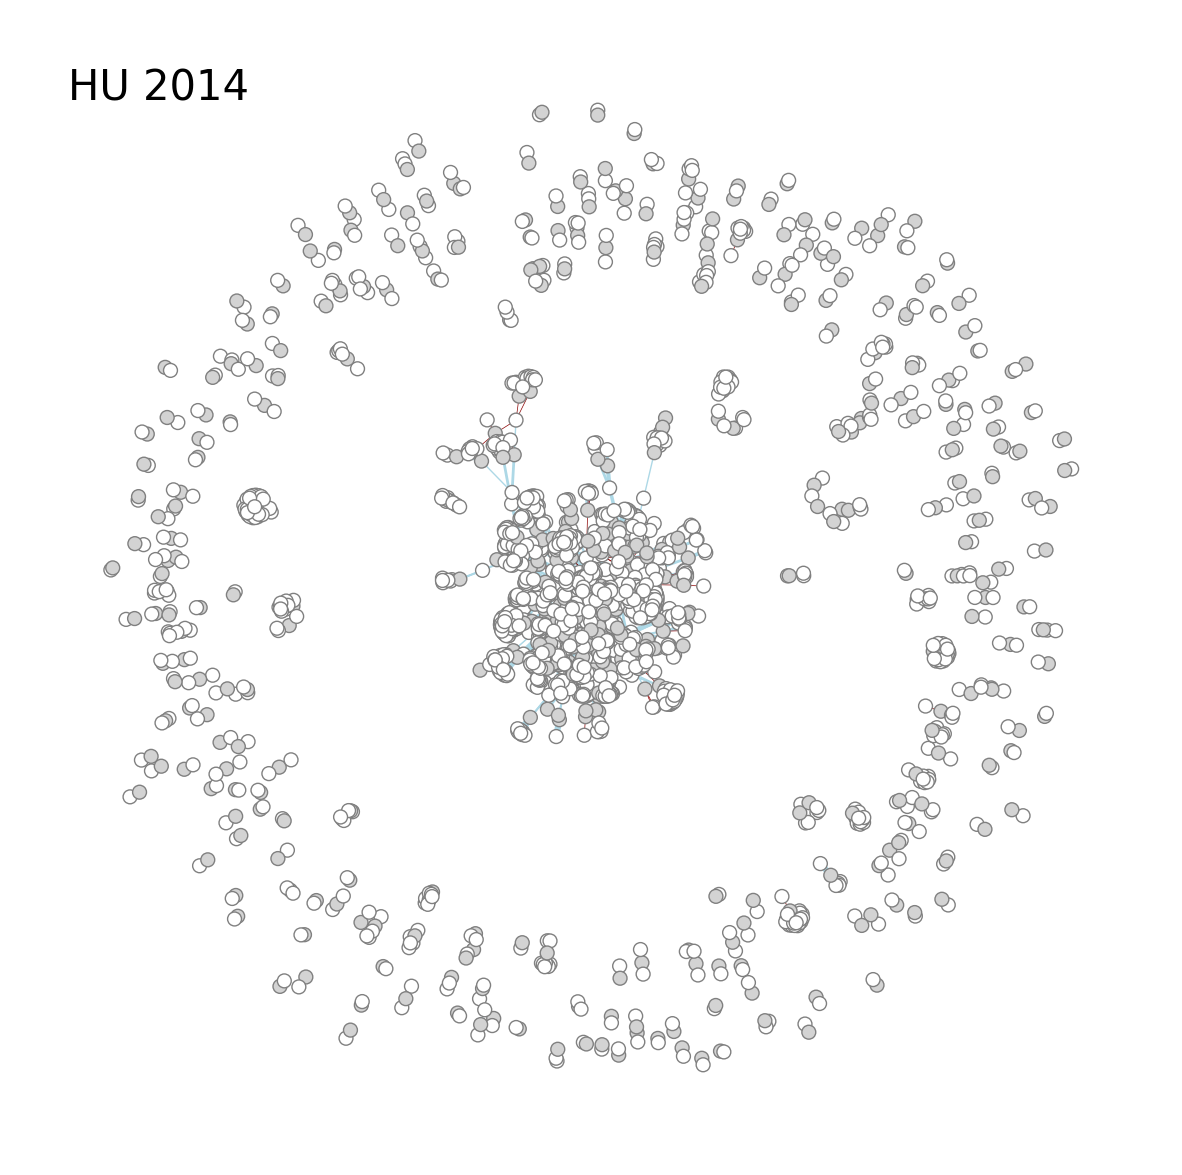

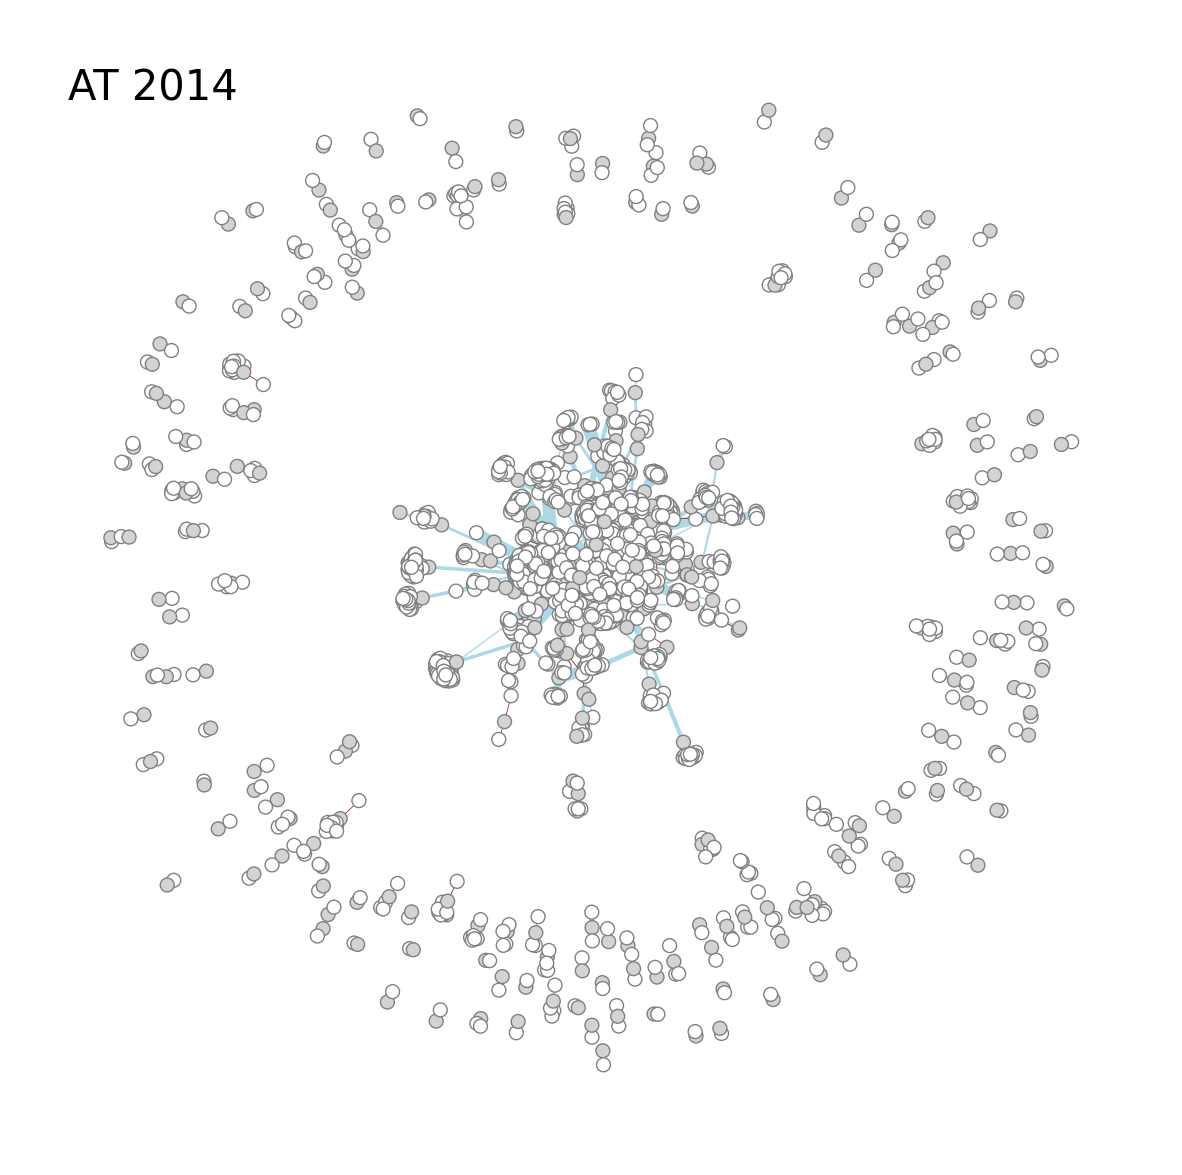

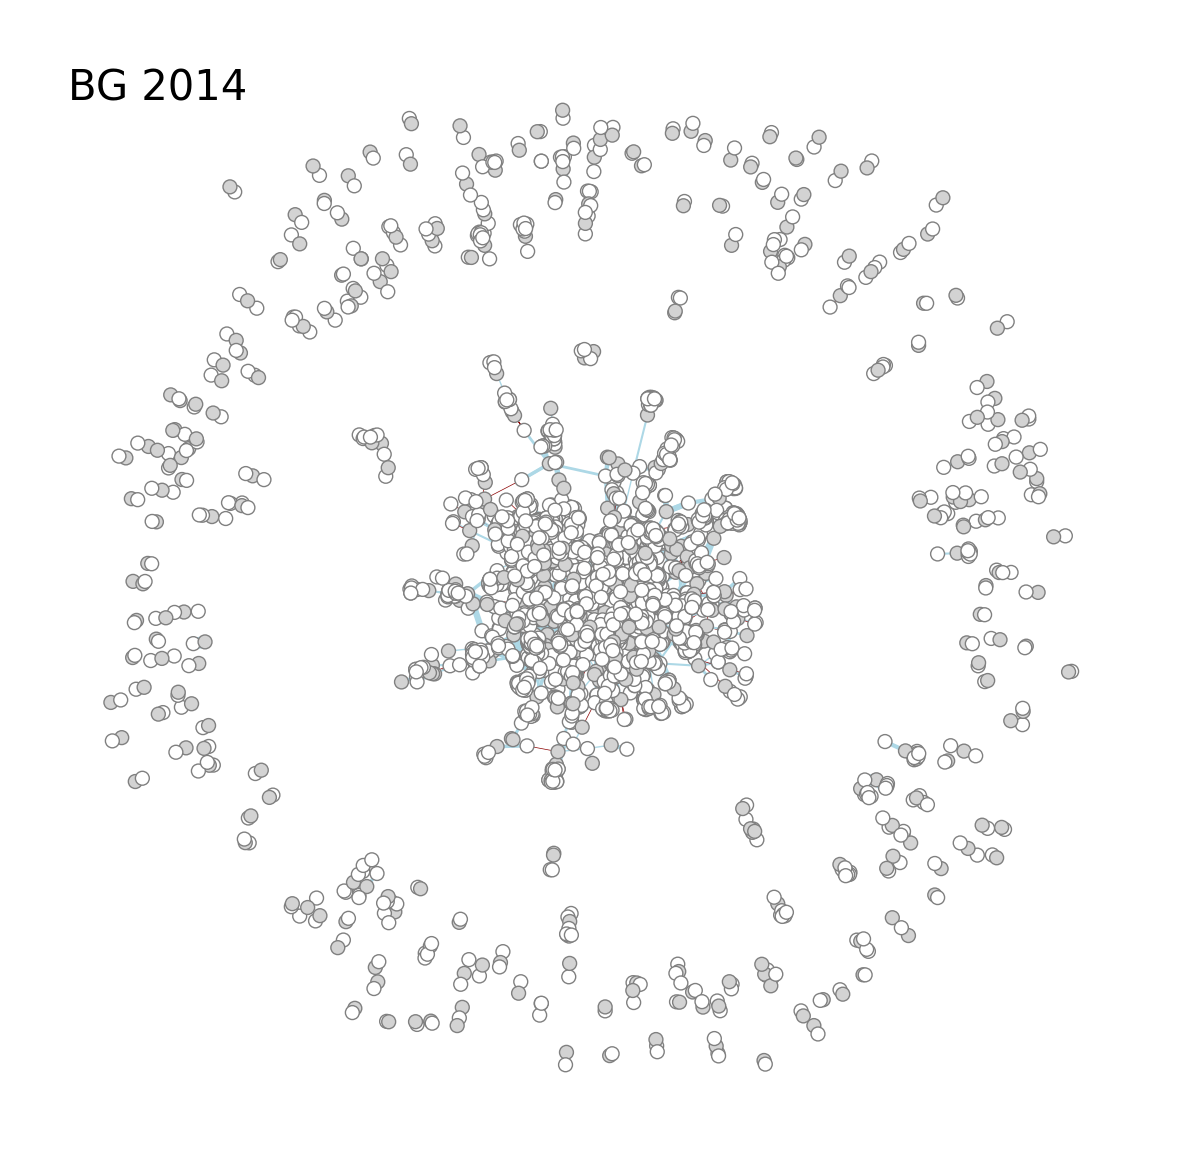

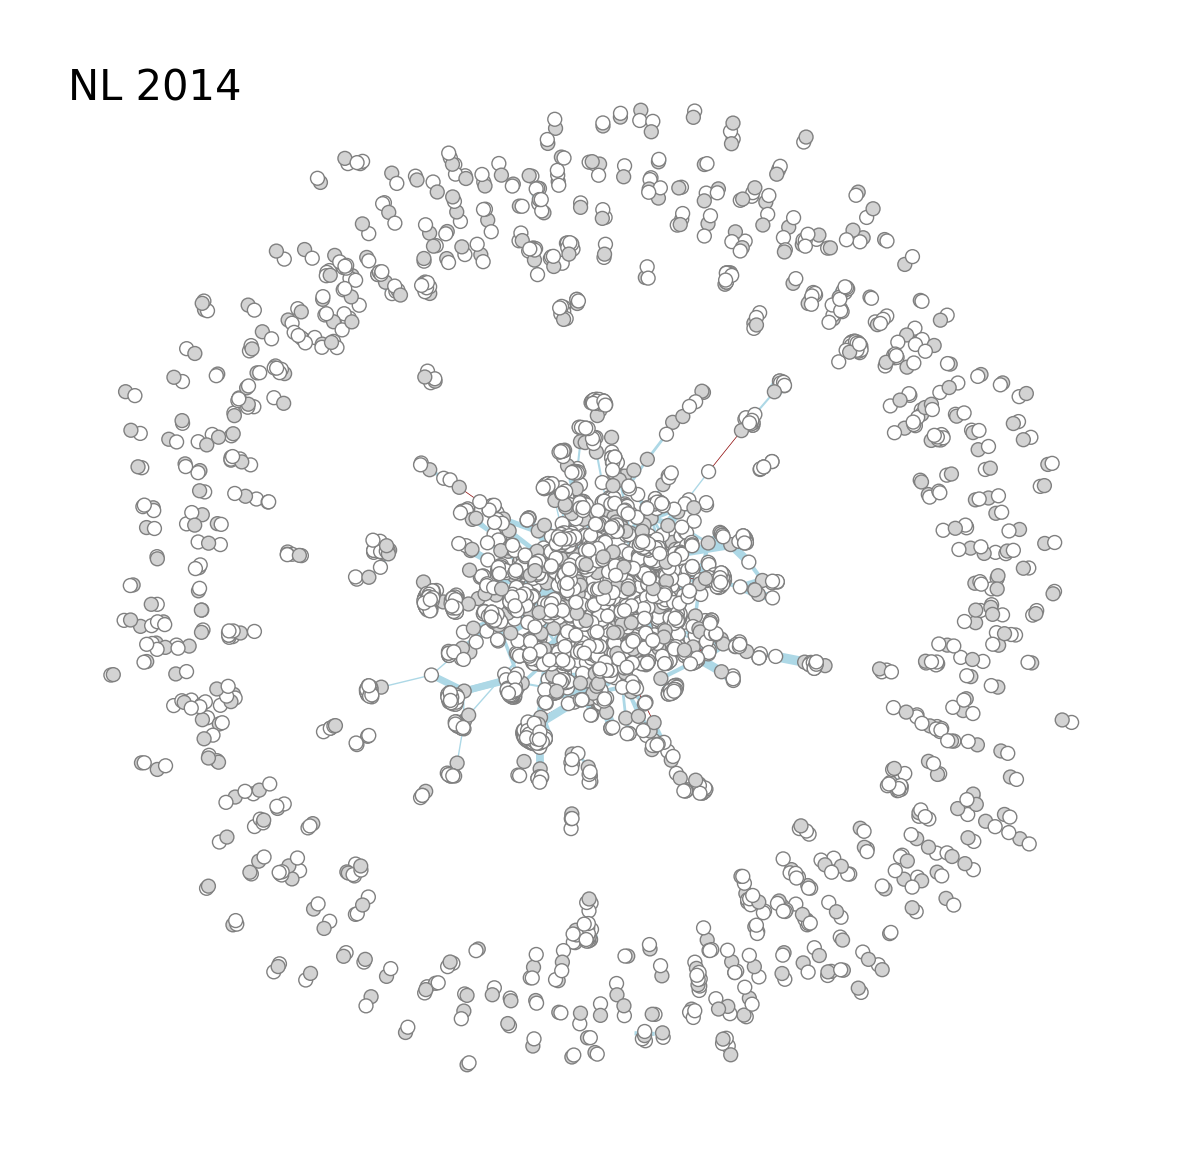

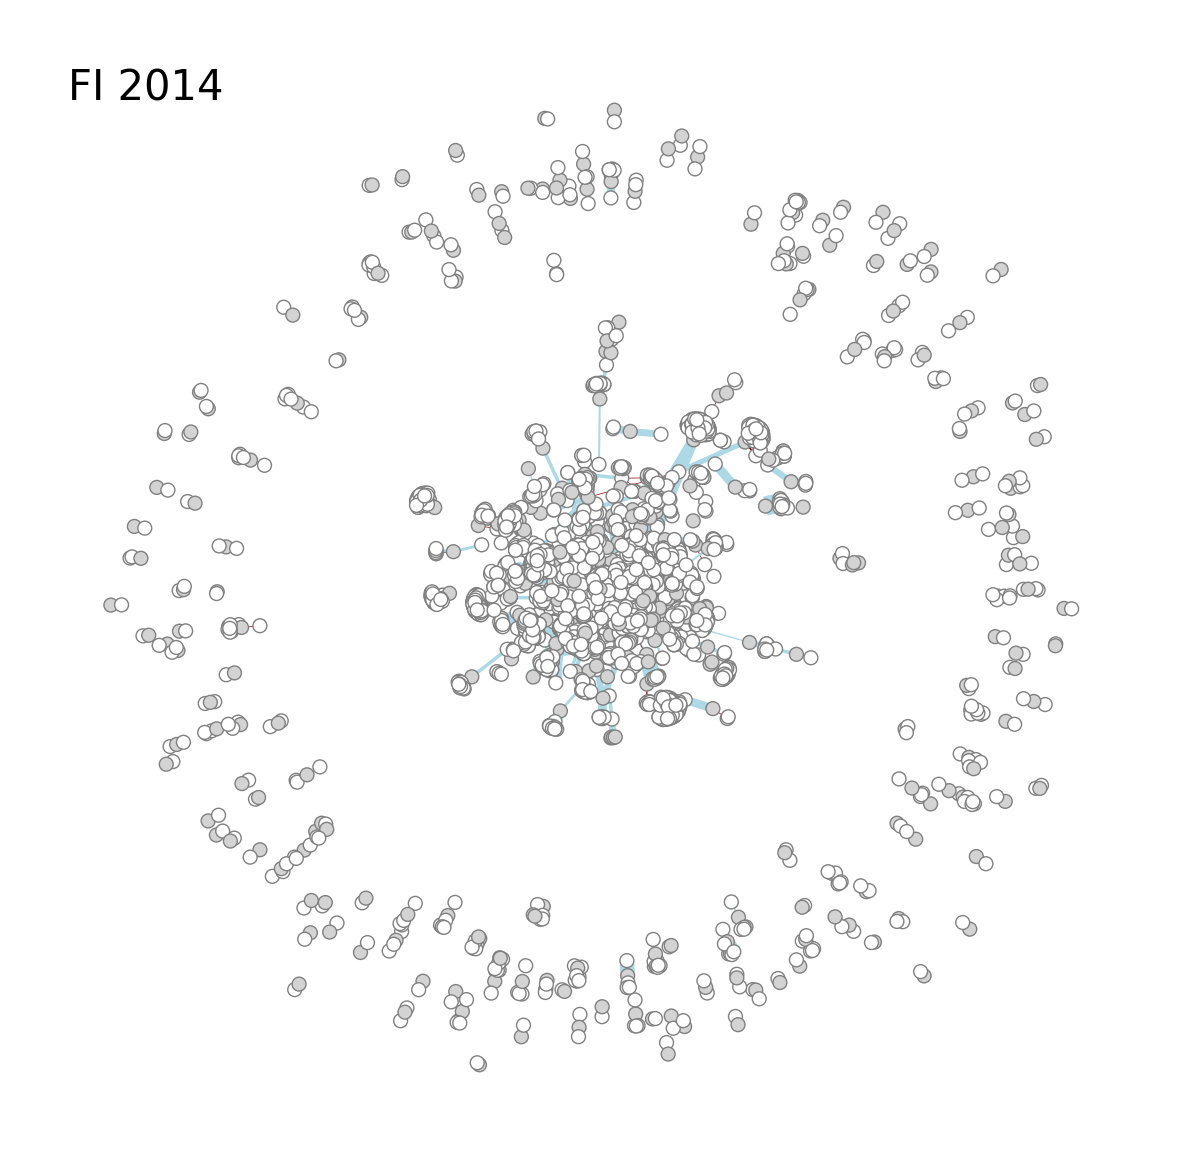

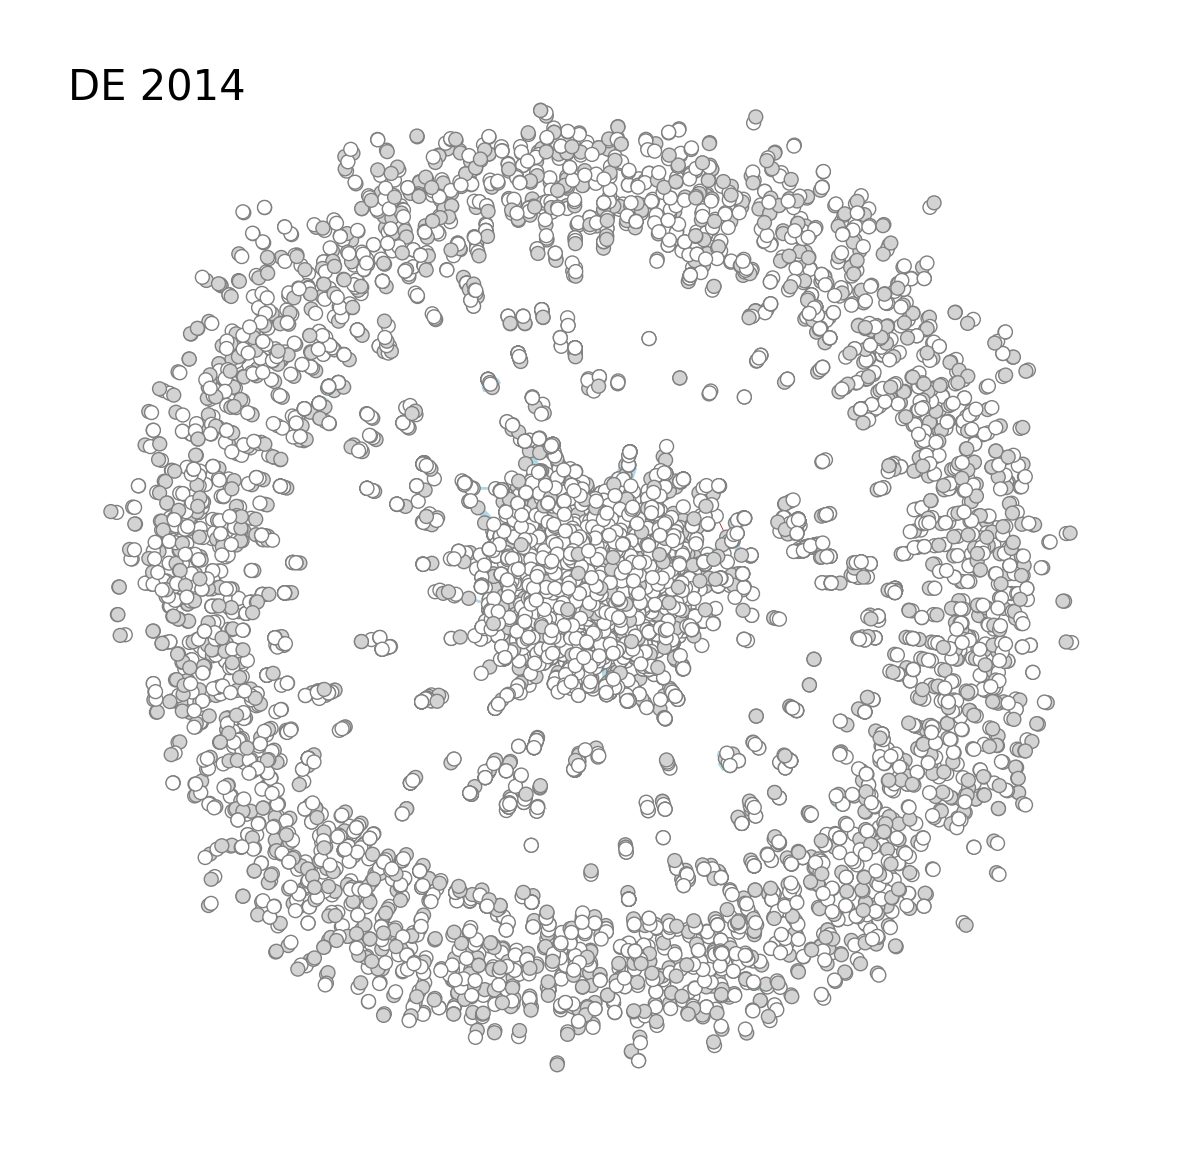

In [49]:
# create plot
country = ['HU', 'AT', 'BG', 'NL', 'FI', 'DE']
for country in country:
  year = 2014

  fig, ax = plt.subplots(figsize=(15,15))

  # Add label to top left corner
  ax.text(0.05, 0.95, f"{country} {year}", fontsize=30, transform=ax.transAxes, ha='left', va='top')

  seed=1
  random.seed(seed)

  # Nodes
  node_size = 100
  node_alpha=0.5
  node_colors = ['lightgray' if node.endswith('i') else 'white' if node.endswith('w') else 'blue' for node in globals()[f"{country}_{year}"].nodes()]

  # Edges
  edge_alpha=0.7
  weights = nx.get_edge_attributes(globals()[f"{country}_{year}"], 'n_bids')
  weights = {edge: weight * 0.5 for edge, weight in weights.items()}
  edge_colors = ['darkred' if globals()[f"{country}_{year}"].get_edge_data(*edge)[list(globals()[f"{country}_{year}"].get_edge_data(*edge).keys())[0]]['sbr_above_50']==1 else 'lightblue' for edge in globals()[f"{country}_{year}"].edges()]

  # Plot the graph
  pos = nx.spring_layout(globals()[f"{country}_{year}"], seed=seed)
  nx.draw(globals()[f"{country}_{year}"], pos, with_labels=False, edgecolors='gray', node_size=node_size, node_color=node_colors, 
                      edge_color=edge_colors, width=list(weights.values()))
  
  plt.savefig('../output/figures/graph_' + str(country) + "_" + str(year) + '.png', bbox_inches='tight')
  plt.show()
  

### Summary statistics of DE subgraphs from 2008 to 2016

In [182]:
contracts_merged_DE = contracts_merged[contracts_merged['issuer_country']=="DE"]

In [184]:
count = contracts_merged_DE.groupby(['issuer_id_final', 'winner_id_final', 'year', 'issuer_country']).size()
count_df = count.to_frame(name = 'count').reset_index()

In [185]:
contracts_merged_DE = contracts_merged_DE.merge(count_df, how='left', left_on=['issuer_country', 'year'], right_on=['issuer_country', 'year'])

MemoryError: Unable to allocate 52.8 GiB for an array with shape (7091790684,) and data type int64

In [104]:
DE = nx.from_pandas_edgelist(contracts_merged_DE, source='issuer_id_final', target='winner_id_final', edge_key='tender_id',  edge_attr=['year', 'n_bids', 'nocft', 'single_bidder', 'sbr_above_50', 'est_value', 'contract_value'], create_using=nx.MultiGraph)

# set node attributes for issuer
issuer_attrs = ['player', 'issuer_name', 'issuer_canonical_name', 'issuer_country', 'issuer_color', 'issuer_address', 'issuer_postcode', 'issuer_town', 'issuer_type', 'issuer_sector']
issuer_attributes = contracts_merged[issuer_attrs + ['issuer_id_final']].drop_duplicates(subset=['issuer_id_final']).set_index('issuer_id_final').to_dict('index')
nx.set_node_attributes(DE, issuer_attributes, 'issuer')

# set node attributes for winner
winner_attrs = ['player', 'winner_name', 'winner_canonical_name', 'winner_country', 'winner_color', 'winner_address', 'winner_postcode', 'winner_town']
winner_attributes = contracts_merged[winner_attrs + ['winner_id_final']].drop_duplicates(subset=['winner_id_final']).set_index('winner_id_final').to_dict('index')
nx.set_node_attributes(DE, winner_attributes, 'winner')

In [105]:
# print basic information about the graph
print("Number of nodes:", DE.number_of_nodes())
print("Number of edges:", DE.number_of_edges())

degrees = [deg for node, deg in DE.degree()]
avg_degree = sum(degrees)/len(DE)
print("Average degree: {:.2f}".format(round(avg_degree, 2)))

wt_degrees = [deg for node, deg in G.degree(weight='n_bids')]
wt_avg_degree = np.nansum(wt_degrees)/len(DE)
print("Weighted average degree: {:.2f}".format(round(wt_avg_degree, 2)))

density = nx.density(DE)
print("Network density: {:.2f}".format(round(density, 2)))


Number of nodes: 88997
Number of edges: 291056
Average degree: 6.54
Weighted average degree: 13.04
Network density: 0.00


In [130]:
# create subgraph
for year in range(2008, 2017):
  country = "DE"

  contracts_merged_DE_year = contracts_merged[((contracts_merged['year']==year)]

  globals()[f"{country}_{year}"] = nx.from_pandas_edgelist(contracts_merged_DE_year, source='issuer_id_final', target='winner_id_final', edge_key='tender_id',  edge_attr=['year', 'n_bids', 'nocft', 'single_bidder', 'sbr_above_50', 'est_value', 'contract_value'], create_using=nx.MultiGraph)

  # set node attributes for issuer
  issuer_attrs = ['player', 'issuer_name', 'issuer_canonical_name', 'issuer_country', 'issuer_color', 'issuer_address', 'issuer_postcode', 'issuer_town', 'issuer_type', 'issuer_sector']
  issuer_attributes = contracts_merged[issuer_attrs + ['issuer_id_final']].drop_duplicates(subset=['issuer_id_final']).set_index('issuer_id_final').to_dict('index')
  nx.set_node_attributes(globals()[f"{country}_{year}"], issuer_attributes, 'issuer')

  # set node attributes for winner
  winner_attrs = ['player', 'winner_name', 'winner_canonical_name', 'winner_country', 'winner_color', 'winner_address', 'winner_postcode', 'winner_town']
  winner_attributes = contracts_merged[winner_attrs + ['winner_id_final']].drop_duplicates(subset=['winner_id_final']).set_index('winner_id_final').to_dict('index')
  nx.set_node_attributes(globals()[f"{country}_{year}"], winner_attributes, 'winner')

KeyboardInterrupt: 

In [ ]:
# create dataframe of summary statistics
DE_summ = pd.DataFrame(columns = ['year', 'edges', 'nodes', 'winners', 'issuers', 'density', 'rac', 'wd_w', 'sd_w', 'wd_i', 'sd_i',
                                  'd_w', 'sd_ww', 'd_i', 'sd_ii'])

In [131]:
weight = 'n_bids'
for year in range(2008, 2017):
  country = "DE"

  DE = globals()[f"{country}_{year}"]

  n_edges = DE.number_of_edges()

  n_nodes = DE.number_of_nodes()

  # n_nodes issuers
  issuer_nodes = [node for node in DE.nodes() if node.endswith('i')]
  issuer_subgraph = DE.subgraph(issuer_nodes)
  n_issuer_nodes = issuer_subgraph.number_of_nodes()

  # n_nodes winners
  winner_nodes = [node for node in DE.nodes() if node.endswith('w')]
  winner_subgraph = DE.subgraph(winner_nodes)
  n_winner_nodes = winner_subgraph.number_of_nodes()

  # degrees
  degrees = [deg for node, deg in DE.degree()]
  avg_degree = sum(degrees)/len(degrees)

  degrees_i = [deg for node, deg in DE.degree() if node.endswith('i')]
  avg_degree_i = sum(degrees_i)/len(degrees_i)
  std_dev_i = np.nanstd(degrees_i)

  degrees_w = [deg for node, deg in DE.degree() if node.endswith('w')]
  avg_degree_w = sum(degrees_w)/len(degrees_w)
  std_dev_w = np.nanstd(degrees_w)

  # weighted degrees
  wt_degrees = [deg for node, deg in DE.degree(weight=weight)]
  wt_avg_degree = np.nansum(wt_degrees)/len(wt_degrees)
  wt_std_dev = np.nanstd(wt_degrees)

  wt_degrees_i = [deg for node, deg in DE.degree(weight=weight) if node.endswith('i')]
  wt_avg_degree_i = np.nansum(wt_degrees_i)/len(wt_degrees_i)
  wt_std_dev_i = np.nanstd(wt_degrees_i)

  wt_degrees_w = [deg for node, deg in DE.degree(weight=weight) if node.endswith('w')]
  wt_avg_degree_w = np.nansum(wt_degrees_w)/len(wt_degrees_w)
  wt_std_dev_w = np.nanstd(wt_degrees_w)

  density = nx.density(DE)
  # bipartite.density(DE, issuer_nodes)

  rac = bipartite.robins_alexander_clustering(DE)

  row = pd.DataFrame({'year':year, 'edges':n_edges, 'nodes':n_nodes,
                      'winners':n_winner_nodes, 'issuers':n_issuer_nodes, 
                      'density':density, 'rac':rac,
                      'wd_w':wt_avg_degree_w, 'sd_w':wt_std_dev_w, 
                      'wd_i':wt_avg_degree_i, 'sd_i':wt_std_dev_i,
                      'd_w':avg_degree_w, 'sd_ww':std_dev_w, 
                      'd_i':avg_degree_i, 'sd_ii':std_dev_i,}, index=[0])
  
  DE_summ = pd.concat([DE_summ.loc[:], row]).reset_index(drop=True)

In [132]:
DE_summ

year  edges  nodes winners issuers   density       rac       wd_w   
0   2008  19627  14863   11430    3433  0.000144  0.011414   9.901312  \
1   2009  23789  16578   12715    3863  0.000144  0.010553   9.862603   
2   2010  30204  17858   14150    3708  0.000144  0.022871  10.881767   
3   2011  28710  18253   14489    3764  0.000144  0.015567   9.082338   
4   2012  31762  19438   15534    3904  0.000144  0.021345   8.846981   
5   2013  34127  20040   15885    4155  0.000144  0.024755   8.167517   
6   2014  37258  20589   16506    4083  0.000144  0.044606   7.644251   
7   2015  40425  22324   17898    4426  0.000144  0.046828   6.918874   
8   2016  45154  25059   19954    5105  0.000144  0.045469   6.925930   
9   2008  19627  14863   11430    3433  0.000178  0.011414   9.901312   
10  2009  23789  16578   12715    3863  0.000173  0.010553   9.862603   
11  2010  30204  17858   14150    3708  0.000189  0.022871  10.881767   
12  2011  28710  18253   14489    3764  0.000172  0.015567   9.082338   
13  2012  31762  19438   15534    3904  0.000168  0.021345   8.846981   
14  2013  34127  20040   15885    4155  0.000170  0.024755   8.167517   
15  2014  37258  20589   16506    4083  0.000176  0.044606   7.644251   
16  2015  40425  22324   17898    4426  0.000162  0.046828   6.918874   
17  2016  45154  25059   19954    5105  0.000144  0.045469   6.925930   

         sd_w       wd_i        sd_i       d_w      sd_ww       d_i      sd_ii  
0   14.657407  24.538887   79.090347  1.717148   2.473526  5.717157  13.571663  
1   15.855715  24.456899   64.440962  1.870940   4.926349  6.158167  16.669298  
2   32.904591  28.963862  126.544526  2.134558  11.032531  8.145631  39.993147  
3   15.018758  26.517269   74.723973  1.981503   3.383826  7.627524  18.088399  
4   16.398188  26.148822   79.975409  2.044676   4.041253  8.135758  21.771188  
5   16.068763  23.350662   65.080711  2.148379   4.618702  8.213478  22.193166  
6   15.557909  22.569434   74.512630  2.257240   5.891409  9.125153  28.257645  
7   13.165719  21.278129   67.755518  2.258632   5.366321  9.133529  26.093890  
8   14.192637  23.045642   93.245141  2.262905   5.364217  8.845054  24.876181  
9   14.657407  24.538887   79.090347  1.717148   2.473526  5.717157  13.571663  
10  15.855715  24.456899   64.440962  1.870940   4.926349  6.158167  16.669298  
11  32.904591  28.963862  126.544526  2.134558  11.032531  8.145631  39.993147  
12  15.018758  26.517269   74.723973  1.981503   3.383826  7.627524  18.088399  
13  16.398188  26.148822   79.975409  2.044676   4.041253  8.135758  21.771188  
14  16.068763  23.350662   65.080711  2.148379   4.618702  8.213478  22.193166  
15  15.557909  22.569434   74.512630  2.257240   5.891409  9.125153  28.257645  
16  13.165719  21.278129   67.755518  2.258632   5.366321  9.133529  26.093890  
17  14.192637  23.045642   93.245141  2.262905   5.364217  8.845054  24.876181

In [133]:
DE_summ.to_excel('../output/tables/DE_summary_stats.xlsx', index=True)

In [73]:
# DE_summ.to_excel('../output/tables/DE_summary_stats_contracts.xlsx', index=True)

### Core-peripheral analysis

### Core-peripheral analysis

In [326]:
# k-core consider weight edges
G_sub_simple = nx.Graph(G_sub) # convert multigraph to simple graph
G_sub_k_core = nx.k_core(G_sub_simple, k=2) # compute k-core on simple graph

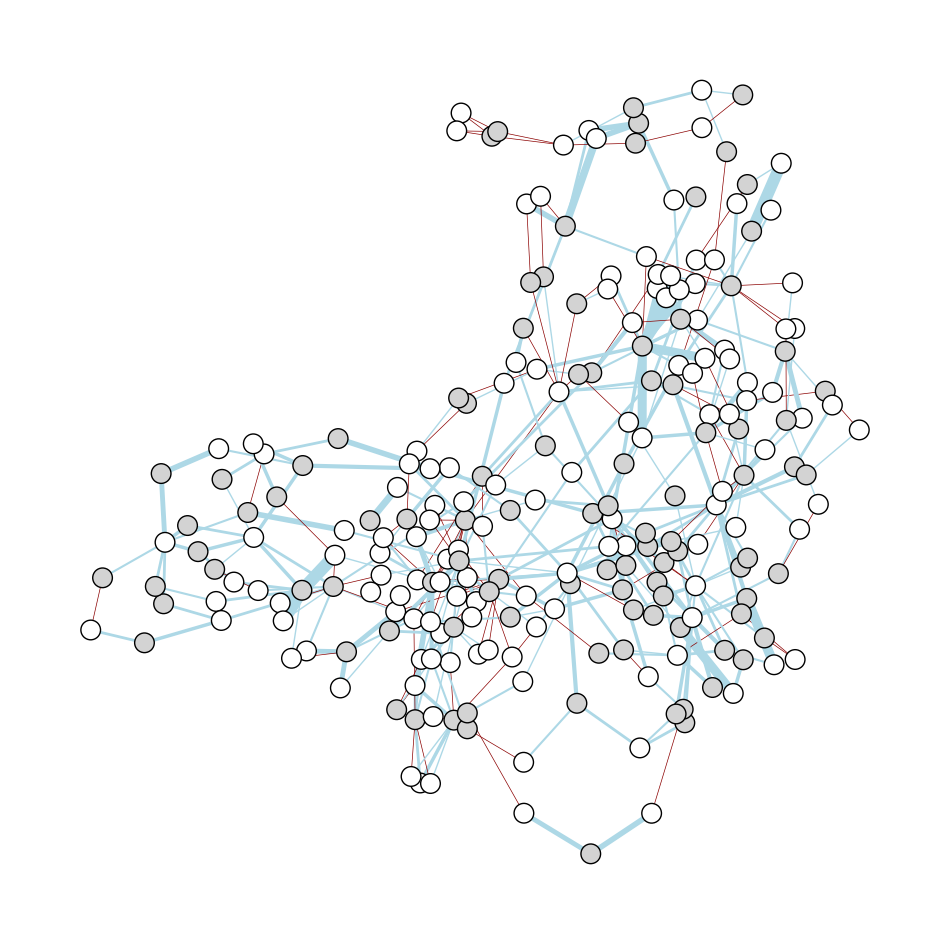

In [354]:
fig, ax = plt.subplots(figsize=(12,12))

random.seed(seed)

# Nodes
node_size = 200
node_alpha=0.5
node_colors = ['lightgray' if node.endswith('i') else 'white' if node.endswith('w') else 'blue' for node in G_sub_k_core.nodes()]

# Edges
edge_alpha=0.7
weights = nx.get_edge_attributes(G_sub_k_core, 'n_bids')
weights = {edge: weight * 0.5 for edge, weight in weights.items()}
edge_colors = ['darkred' if G_sub_k_core.get_edge_data(*edge)['sbr_above_50']==1 else 'lightblue' for edge in G_sub_k_core.edges()]
edge_cmap = plt.cm.Blues

# Plot the graph
pos = nx.spring_layout(G_sub_k_core, seed=seed)
nx.draw(G_sub_k_core, pos, with_labels=False, edgecolors='black', node_size=node_size, node_color=node_colors, 
        edge_color=edge_colors, edge_cmap=edge_cmap, width=list(weights.values()))
# nx.draw_networkx_edges(G_sub_k_core, pos, edge_color=edge_colors, width=list(weights.values()), alpha=0.2) #width=list(weights.values())
plt.show()

In [245]:
print("Number of nodes:", G_sub_k_core.number_of_nodes())
print("Number of edges:", G_sub_k_core.number_of_edges())

Number of nodes: 232
Number of edges: 401


### Community detection

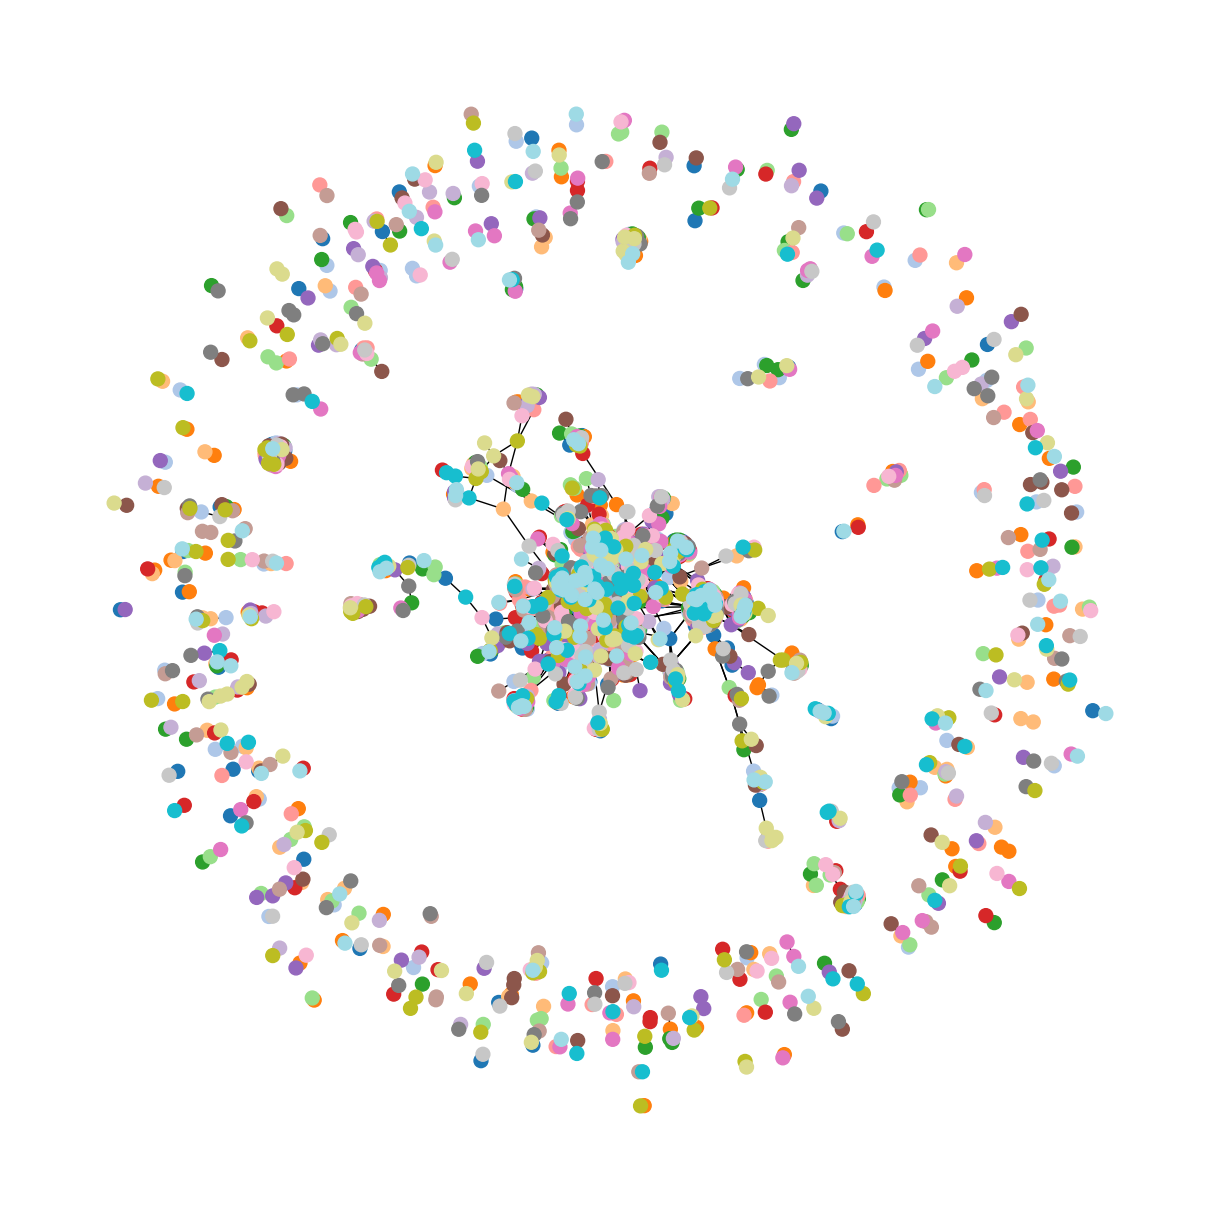

In [393]:
G_sub_comm=nx.community.louvain_communities(G_sub, weight='n_bids', resolution=1, threshold=1e-07, seed=seed)

# Create a dictionary to map nodes to their community index
comm_dict = {}
for i, comm in enumerate(G_sub_comm):
    for node in comm:
        comm_dict[node] = i

node_size=100

# Draw the graph with nodes colored by their community
pos = nx.spring_layout(G_sub, seed=seed)
plt.figure(figsize=(12, 12))
nx.draw(G_sub, pos, node_size=node_size, node_color=[comm_dict[n] for n in G_sub.nodes()], cmap=plt.cm.tab20)
plt.axis('off')
plt.show()

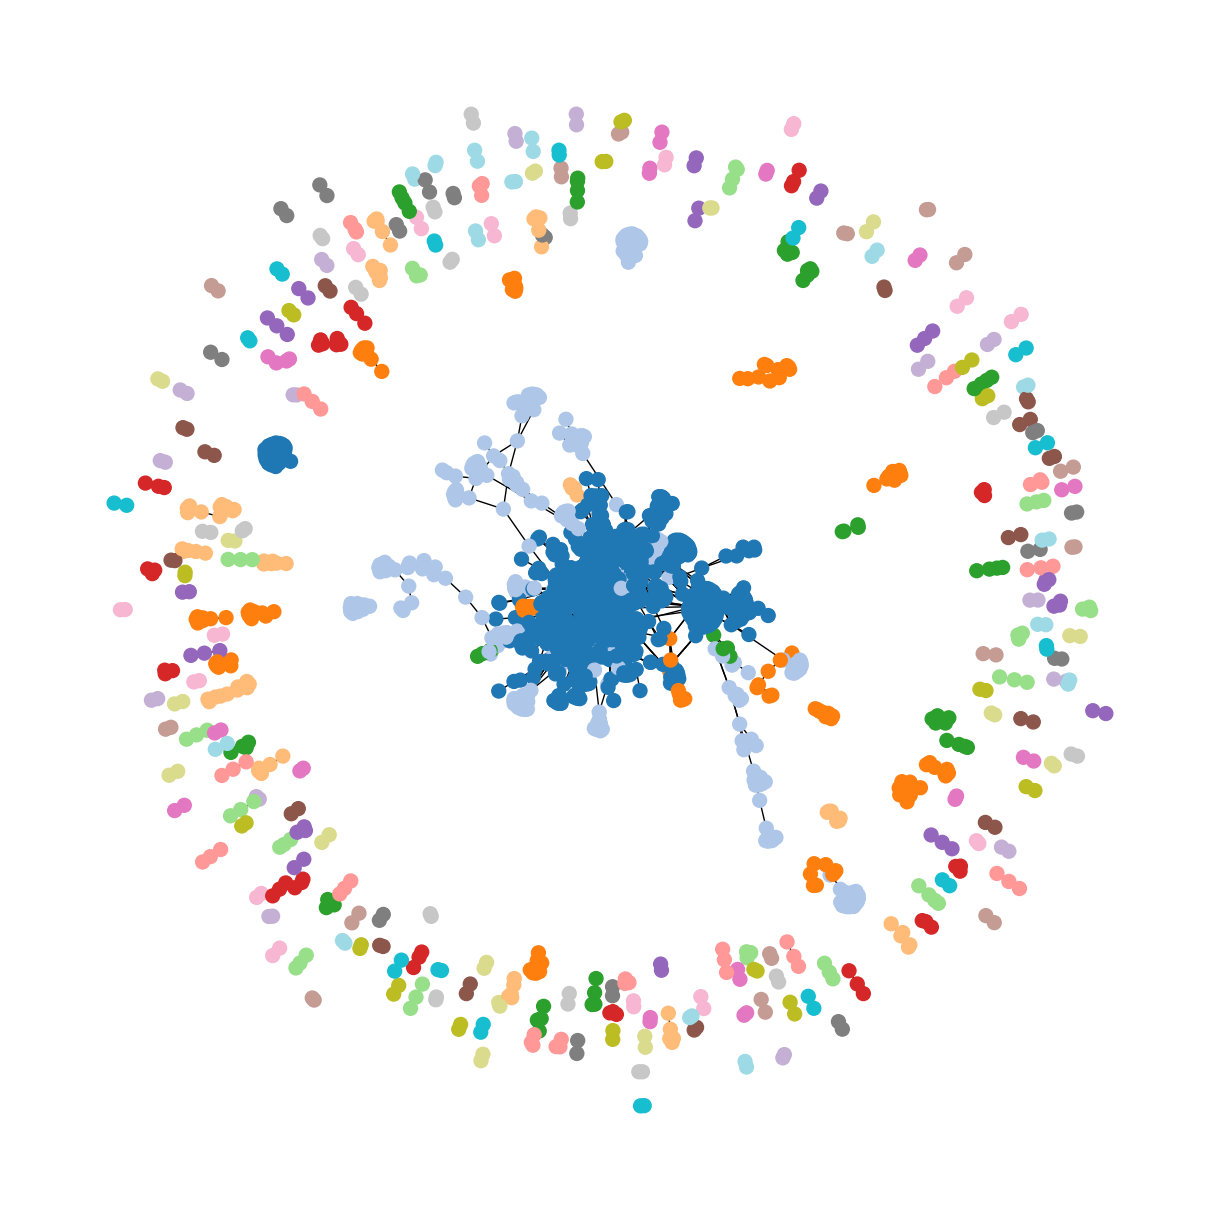

In [392]:
#  Compute the Louvain communities
G_sub_comm = nx.community.greedy_modularity_communities(G_sub)

# Create a dictionary to map nodes to their community index
comm_dict = {}
for i, comm in enumerate(G_sub_comm):
    for node in comm:
        comm_dict[node] = i

node_size=100

# Draw the graph with nodes colored by their community
pos = nx.spring_layout(G_sub, seed=seed)
plt.figure(figsize=(12, 12))
nx.draw(G_sub, pos, node_size=node_size, node_color=[comm_dict[n] for n in G_sub.nodes()], cmap=plt.cm.tab20)
plt.axis('off')
plt.show()

### Largest connected component

In [398]:
connected_component_subgraphs = (G_sub.subgraph(c) for c in nx.connected_components(G_sub))

largest_subgraph = max(connected_component_subgraphs, key=len)

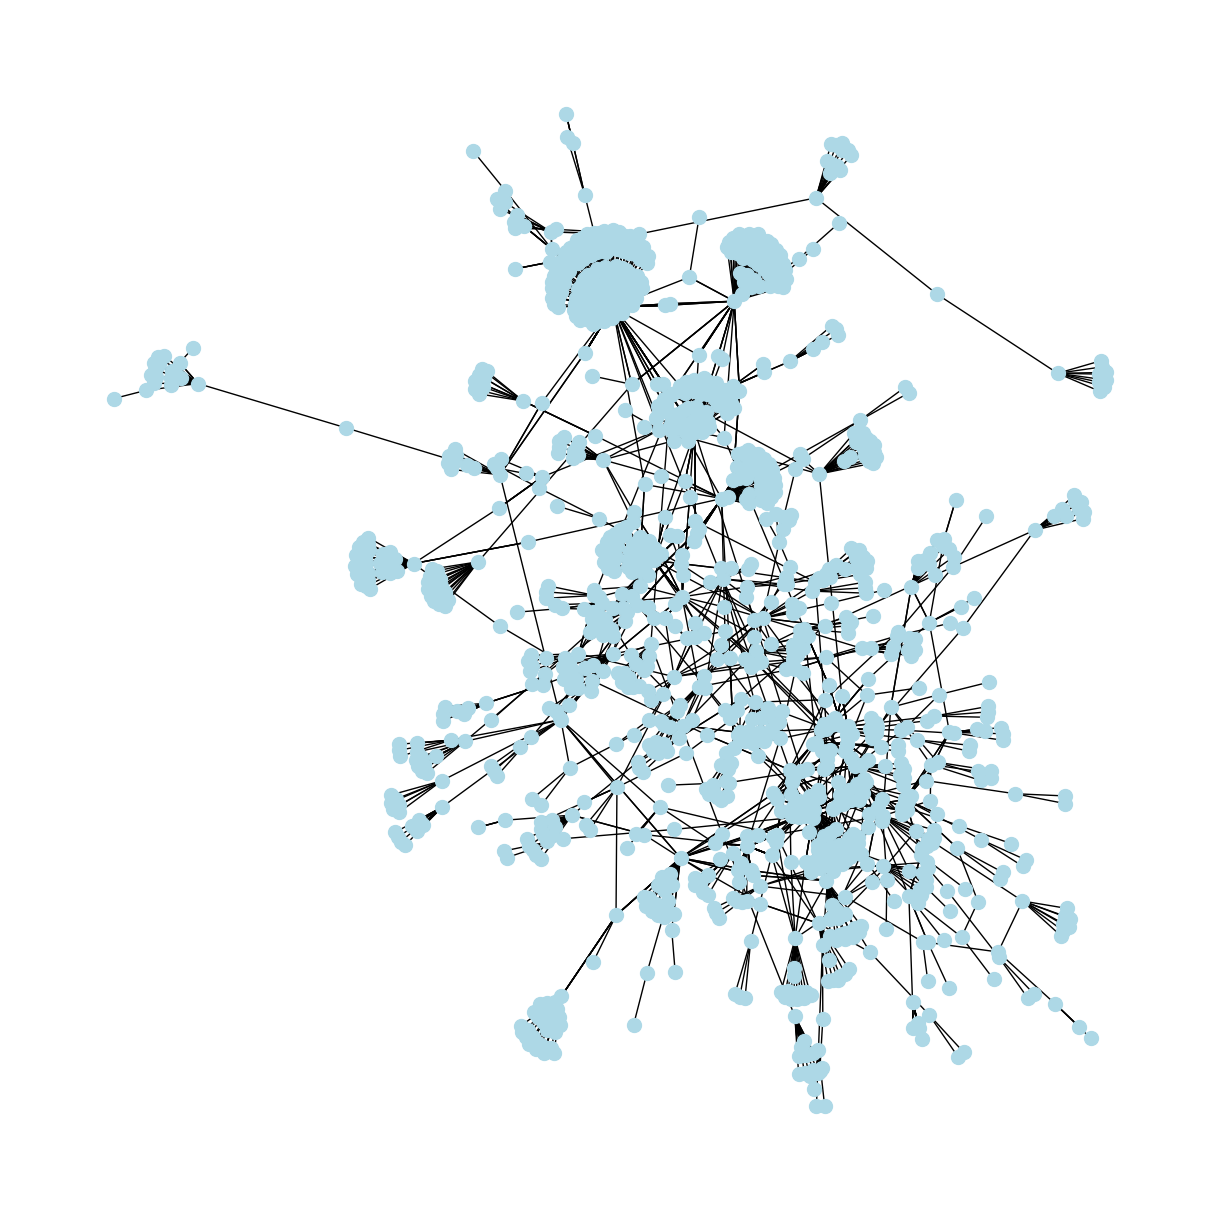

In [403]:
node_size=100

# Draw the graph with nodes colored by their community
pos = nx.spring_layout(largest_subgraph, seed=seed)
plt.figure(figsize=(12, 12))
nx.draw(largest_subgraph, pos, node_size=node_size, node_color="lightblue")
plt.axis('off')
plt.show()

In [235]:
# TODO main research question
# single_bidder: 1 if there was no competition for the contract
# contract_eu_funded: 1 if the contract was supported by EU funding
# est_value: the raw estimated value of the contract (currency/VAT unclear)
# contract_value: the raw value of the contract (currency/VAT unclear )

## Descriptives

In [363]:
degree_centrality = nx.degree_centrality(G_sub_k_core)
betweenness_centrality = nx.betweenness_centrality(G_sub_k_core)
closeness_centrality = nx.closeness_centrality(G_sub_k_core)
eigenvector_centrality = nx.eigenvector_centrality(G_sub_k_core)


In [365]:
print("Degree centrality:", degree_centrality)
print("Betweenness centrality:", betweenness_centrality)
print("Closeness centrality:", closeness_centrality)
print("Eigenvector centrality:", eigenvector_centrality)

Degree centrality: {'60_HU_w': 0.008658008658008658, '2_HU_i': 0.06060606060606061, '484_HU_w': 0.008658008658008658, '330_HU_i': 0.008658008658008658, '5942_HU_w': 0.017316017316017316, '600_HU_w': 0.008658008658008658, '325_HU_i': 0.017316017316017316, '1422_HU_w': 0.008658008658008658, '1288_HU_w': 0.008658008658008658, '6807_HU_w': 0.012987012987012988, '2322_HU_w': 0.012987012987012988, '192_HU_i': 0.008658008658008658, '774_HU_i': 0.008658008658008658, '352_HU_w': 0.008658008658008658, '69_HU_i': 0.021645021645021644, '2006_HU_w': 0.008658008658008658, '1047_HU_w': 0.008658008658008658, '650_HU_i': 0.012987012987012988, '1022_HU_w': 0.012987012987012988, '941_HU_w': 0.008658008658008658, '442_HU_w': 0.008658008658008658, '2036_HU_w': 0.012987012987012988, '6245_HU_w': 0.008658008658008658, '1297_HU_w': 0.008658008658008658, '862_HU_w': 0.012987012987012988, '208_HU_i': 0.012987012987012988, '1867_HU_w': 0.030303030303030304, '1120_HU_w': 0.04329004329004329, '724_HU_w': 0.0129870

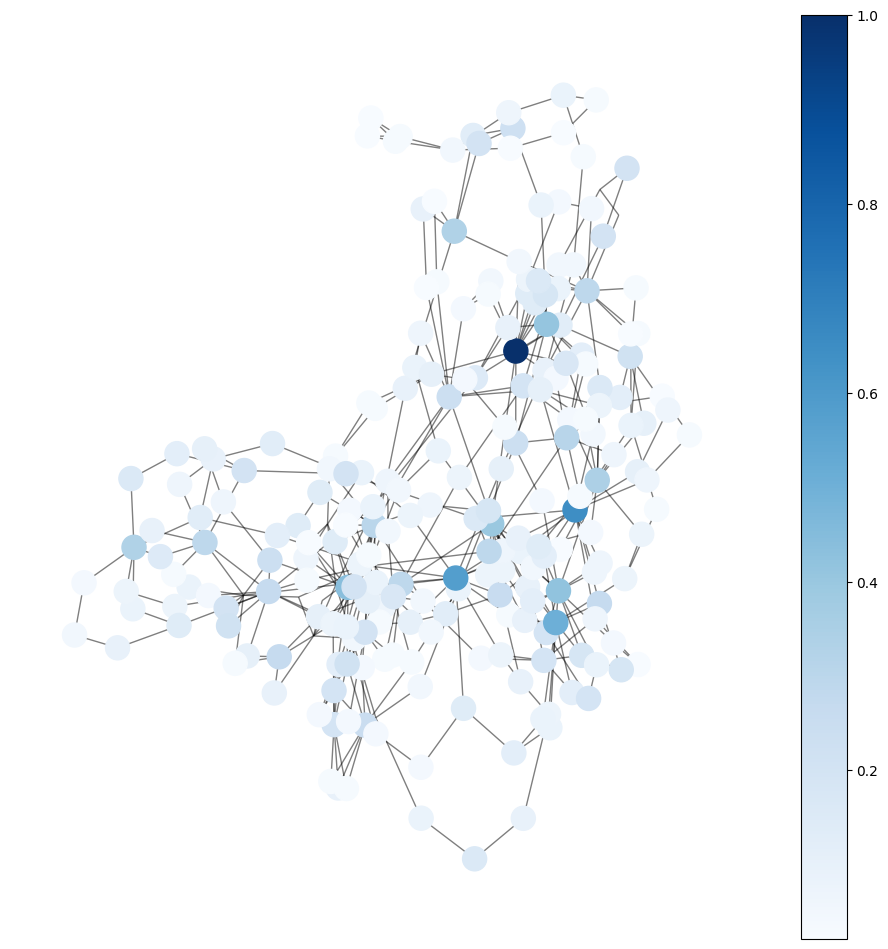

In [371]:
# Compute weighted degree centrality
wdc = G_sub_k_core.degree(weight='n_bids')

# Extract node names and normalized weighted degree values
nodes, wdc_values = zip(*wdc)
wdc_values_normalized = [x/max(wdc_values) for x in wdc_values]

# Create color map
cmap = plt.cm.Blues

# Draw the graph with nodes colored by weighted degree centrality
pos = nx.spring_layout(G_sub_k_core, seed=seed)
plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G_sub_k_core, pos, alpha=0.5)
node_sm = nx.draw_networkx_nodes(G_sub_k_core, pos, node_color=wdc_values_normalized, cmap=cmap)

# Add colorbar to the plot
plt.colorbar(node_sm, ax=plt.gca())
plt.axis('off')
plt.show()


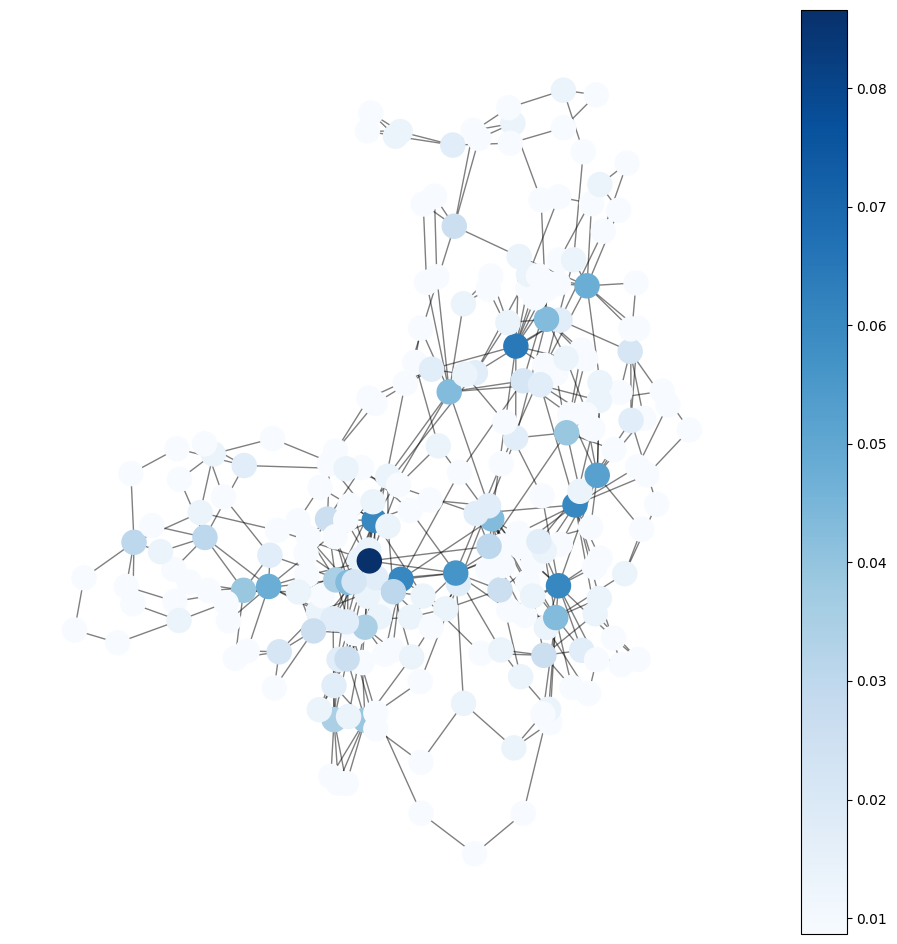

In [370]:
# Compute weighted degree centrality
random.seed(seed)
wdc = nx.degree_centrality(G_sub_k_core)

# Draw the graph with nodes colored by weighted degree centrality
pos = nx.spring_layout(G_sub_k_core, seed=seed)
plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G_sub_k_core, pos, alpha=0.5)
node_sm = nx.draw_networkx_nodes(G_sub_k_core, pos, node_color=list(wdc.values()), cmap=plt.cm.Blues)

# Add colorbar to the plot
plt.colorbar(node_sm, ax=plt.gca())
plt.axis('off')
plt.show()


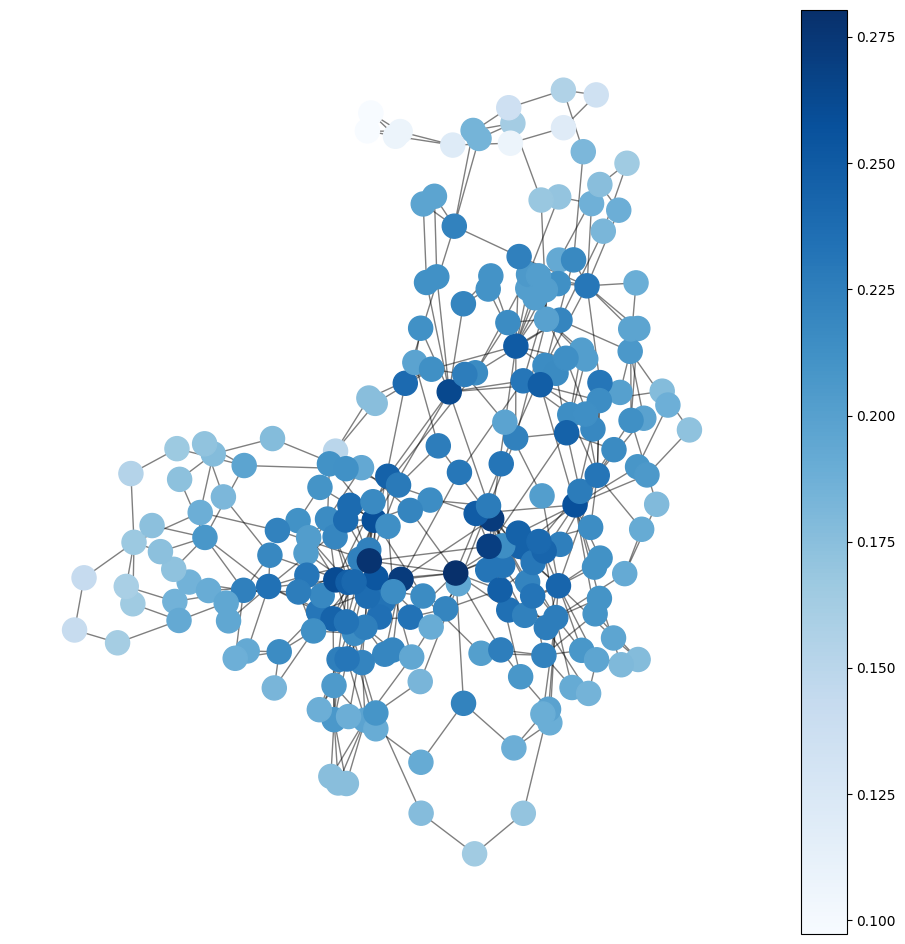

In [355]:
# Compute node closeness centrality
random.seed(seed)

bc = nx.closeness_centrality(G_sub_k_core)

# Draw the graph with nodes colored by closeness centrality
pos = nx.spring_layout(G_sub_k_core, seed=seed)
plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G_sub_k_core, pos, alpha=0.5)
node_sm = nx.draw_networkx_nodes(G_sub_k_core, pos, node_color=list(bc.values()), cmap=plt.cm.Blues)

# Add colorbar to the plot
plt.colorbar(node_sm, ax=plt.gca())
plt.axis('off')
plt.show()


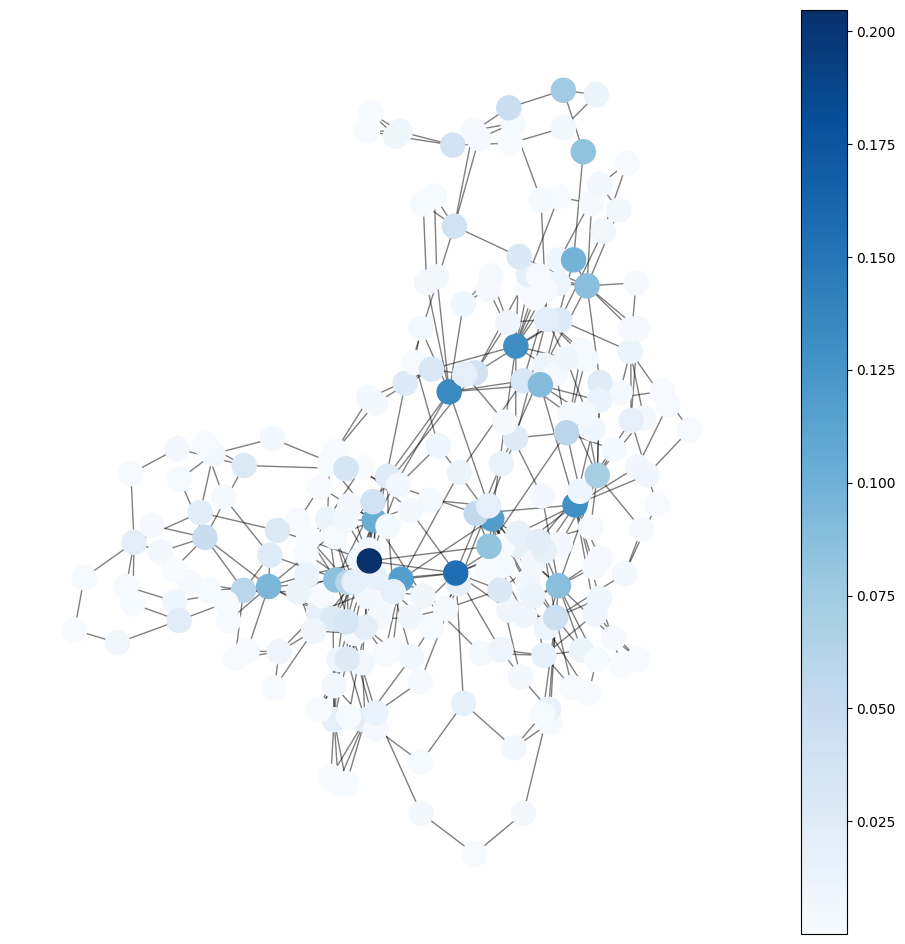

In [356]:
# Compute node betweenness centrality
random.seed(seed)

bc = nx.betweenness_centrality(G_sub_k_core)

# Draw the graph with nodes colored by betweenness centrality
pos = nx.spring_layout(G_sub_k_core, seed=seed)
plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G_sub_k_core, pos, alpha=0.5)
node_sm = nx.draw_networkx_nodes(G_sub_k_core, pos, node_color=list(bc.values()), cmap=plt.cm.Blues)

# Add colorbar to the plot
plt.colorbar(node_sm, ax=plt.gca())
plt.axis('off')
plt.show()
